In [2]:
"""
Original EAP/AAP experiment

Note that this used the wrong scores -> possibly hhi (not sure) but definitely
    euclidean distance. See exp1_eap_aap_umap_updated for where we use JSD for
    EmNLP camera ready
"""
# For Leonie AAP EAP CEC - this was initially copied from exp5_extract
# see what we can find about those constructions

# - note that Aligned examples says "hhi" but the scores are actually surprisal
# - multithat examples (currently we are skipping them - only for the umap part, I think)

%load_ext autoreload
%autoreload 2


In [3]:
from pprint import pp
from collections import Counter
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple

# change here to get the main paper vs appendix results
# will correct errors in the original dataset
# as well as one pipeline error

# do_correct = False
do_correct = True



# read in data

In [5]:
from rozlib.libs.common.data.utils_jsonl import read_from_jsonl
from corpus_tools.zhou_cxs_so_difficult.corpus_leonie_eap_aap_cec import get_clean_exs, fix_labels
from proj.cxs_are_revealed.paper.cxns_in_distrib.exp1_zhou.exp1_utils import align_mlm_results_with_input_data
from lib.exp_common.mlm_result_for_sentence import MLMResultForSentence
from proj.cxs_are_revealed.paper.data_config import Exp1Zhou

# read in mlm RoBERTA scores outputs
# for the affinity matrix, we have only original HHI scores

# note used euclidean dist since score matrix has scores up to 1.4, which is sqrt(2) and euclid dist max
#   not sure if the diagonal was hhi or probability;  we wrote above that it's surprisal, but I think it might be HHI
mlm_results_hhi = read_from_jsonl(
    Exp1Zhou.zhou_affinities_hhi_euclid,
    # Exp1Zhou.zhou_all_core_outputs,    -> see _updated.ipynb
    MLMResultForSentence
)

print(len(mlm_results_hhi))

# read in original data
all_exs = get_clean_exs(Exp1Zhou.zhou_original_xlsx,print_errors=False)
print(len(all_exs))

aligned_results_hhi = align_mlm_results_with_input_data(mlm_results_hhi, all_exs)

# note: all come in sets of 5 (we implemented zhou's 5 different perturbations,
#  but we only consider the unperturbed versions here)
print(len(aligned_results_hhi)/5)
print(len(aligned_results_hhi))
# 8 examples didn't run because of accents

# pp(aligned_results_hhi[0])



/Users/jsrozner/docs_local/research/proj_code/rozner-mono-cxs-main/proj/cxs_are_revealed/src/corpus_tools/zhou_cxs_so_difficult/corpus_leonie_eap_aap_cec.py:35: UserWarning: in get_all_exs for leonie corpus; minimal clean is set to FALSE
  warnings.warn(f"in get_all_exs for leonie corpus; minimal clean is set to {str(minimal_clean).upper()}")


1290
Initially read in 323 examples
num exs after remove errors: 285
285
Northern Liang's duke Juqu Mengxun became so apprehensive that he offered to yield his territory and relocate his entire army into Later Qin proper.
missing Hergé became so annoyed that Casterman then sent the book to the printers without his final approval.
She was so determined that she continued her training even after breaking both her wrists in a childhood accident.
missing After Villa's raid on Ciudad Juárez in June 1919 (in which Ángeles did not participate), Ángeles became so despondent that there was no solution to the long and bloody civil war.
The people were so elated that their livelihoods remained intact, even though much of their town was destroyed.
missing King Pedro IV was so elated that he proclaimed St. Francis his savior and renamed his base São Francisco de Kibangu.
My mother was so horrified that she fell ill.
missing For example, Zhu Youliang () the Prince of Heng, an older cousin of the emp

In [6]:
# check max scores in the score matrix to see if it's euclidean or JSD
def check_max():
    score_list = []
    for m in mlm_results_hhi:
        scores = m.score_matrix_distribution
        scores_flat = [x for subl in scores
                       for x in subl]
        score_list.extend(scores_flat)
    score_list = sorted(score_list)
    return score_list

sl = check_max()
print(sl[-5:])
# sqrt(2) ~ 1.4...so seems to be euclidean
# not sure about diagonal if it's hhi or surprisal, since we have the note at the top
# that says surprisal



[1.402720332145691, 1.4040277004241943, 1.404266595840454, 1.4054630994796753, 1.4073387384414673]


In [ ]:
# copied mostly from exp5_extract
def find_in_aligned(id: int):
    res = [e for e in aligned_results_hhi if e.orig_example.id == id]
    print(len(res))
    assert len(res) == 5
    return res

# def correct():
#     """
#     Fix zhu you liang which somehow had the wrong value - manually fix
#     """
#     res = find_in_aligned(72)
#     one_res = res[0]
#     # note difference - we are using HHI not suprisal here
#     one_res.mlm_result.hhi_scores[one_res.orig_example.so_idx] = 0.99

if do_correct:
    fix_labels(all_exs)
    # this particular example did not show here (likely due to pipeline issue)
    # correct()


# Graph embeddings

In [14]:
#######
# graph embeddings!
########

# for the examples, we 
# - add the hhi scores along diagonal
# - get the indices we want to keep
# - truncate the score matrix
# -  plot with umap...

In [15]:
from rozlib.libs.library_ext_utils.utils_spacy import NLPWithCache

# from utils.utils_spacy import NLPWithCache

# use a spacy parser that has a cache
nlp = NLPWithCache()


Initialized NLP with model name en_core_web_trf and cache


/opt/homebrew/Caskroom/miniconda/base/envs/2024_coelm/lib/python3.12/site-packages/thinc/shims/pytorch.py:253: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state

In [16]:
# matrix helper methods

import torch
def normalize_affinity_matrix(matrix: torch.Tensor) -> torch.Tensor:
    """
    Normalize an affinity matrix using z-score normalization.

    Args:
        matrix (torch.Tensor): 2D tensor (affinity matrix with positive scores).

    Returns:
        torch.Tensor: Normalized affinity matrix with z-scores.
    """
    if len(matrix.shape) != 2:
        raise ValueError("Input must be a 2D tensor.")

    # Compute mean and standard deviation of the matrix
    mean = torch.mean(matrix)
    std = torch.std(matrix)

    if std == 0:
        raise ValueError("Standard deviation is zero; normalization is undefined.")

    # Apply z-score normalization
    normalized_matrix = (matrix - mean) / std
    return normalized_matrix

def get_topk_indices(matrix: torch.Tensor, k: int):
    """
    Find the indices (i, j) of the top k values in a 2D tensor.

    Args:
        matrix (torch.Tensor): Input 2D tensor.
        k (int): Number of top values to find.

    Returns:
        list of tuples: List of (i, j) indices of the top k values in the matrix.
    """
    if len(matrix.shape) != 2:
        raise ValueError("Input must be a 2D tensor.")

    if k > matrix.numel():
        raise ValueError(f"k ({k}) cannot be larger than the number of elements in the matrix ({matrix.numel()}).")

    # Flatten the matrix and get the top k values and their linear indices
    topk_values, topk_linear_indices = torch.topk(matrix.flatten(), k)

    # Convert linear indices to 2D indices
    topk_indices = [
        (torch.div(idx, matrix.size(1), rounding_mode='floor').item(), (idx % matrix.size(1)).item())
        for idx in topk_linear_indices
    ]

    return topk_indices

def extract_values_from_indices(matrix: torch.Tensor, indices: list):
    """
    Extract the values from a 2D tensor at the given list of (i, j) indices.

    Args:
        matrix (torch.Tensor): Input 2D tensor.
        indices (list of tuples): List of (i, j) indices to extract values from.

    Returns:
        torch.Tensor: A 1D tensor containing the extracted values.
    """
    if len(matrix.shape) != 2:
        raise ValueError("Input must be a 2D tensor.")

    # Separate the list of tuples into row and column indices
    row_indices, col_indices = zip(*indices)

    # Use advanced indexing to extract the values
    extracted_values = matrix[list(row_indices), list(col_indices)]

    return extracted_values

def topk_values_from_matrix(matrix: torch.Tensor, topk: int):
    topk_idcs = get_topk_indices(matrix, topk)
    return extract_values_from_indices(matrix, topk_idcs)


In [22]:
from corpus_tools.zhou_cxs_so_difficult.corpus_leonie_eap_aap_cec import BaseExample
from rozlib.libs.library_ext_utils.utils_torch import torch_fill_diagonal
from lib.exp_common.mlm_result_for_sentence import MLMResultForSentence
from proj.cxs_are_revealed.paper.cxns_in_distrib.exp1_zhou.exp1_utils import ResultWrapper, get_other_pos_idxs
import torch
# from utils.corpus.corpus_leonie_eap_aap_cec import BaseExample
# from paper.exp1_zhou.exp5_utils import get_other_pos_idxs


# get a list of graphs + their labels (for plotting with umap)
@dataclass
class GraphForEmbed:
    adjusted_matrix: torch.Tensor
    aligned_ex: ResultWrapper
    idxs_to_keep: List[int]


def process_score_matrix(
        mlm_res: MLMResultForSentence,
        idxs_to_keep: List[int],
        do_normalize=False,
        add_hhis=False
) -> torch.Tensor:
    """
    args: original score matrix, 
    should insert hhis along diagonal
    keep only appropriate indices
    
    potentially normalize
    """
    # todo: review uses of torch.Tensor instead of torch.tensor for initialization
    orig_score_matrix = torch.tensor(mlm_res.score_matrix_distribution)
    hhis = torch.tensor(mlm_res.hhi_scores)
    
    if do_normalize:
        orig_score_matrix = normalize_affinity_matrix(orig_score_matrix)
        torch_fill_diagonal(orig_score_matrix, torch.zeros_like(hhis))
    
    if add_hhis:
        # write hhis along diagonal
        # print("filling hhis on diagonal", orig_score_matrix.shape, hhis.shape)
        torch_fill_diagonal(orig_score_matrix, hhis)
    
    idxs = torch.tensor(idxs_to_keep)
    filtered_tensor = orig_score_matrix[idxs][:, idxs]
    
    return filtered_tensor

def get_canonical_idxs(
    base_ex: BaseExample,
    spacy_parsed_idxs: Tuple[int, int, int, int]
) -> List[int]:

    main_verb_idx, main_subj_idx, clause_verb_idx, clause_subj_idx = spacy_parsed_idxs
    return [
        main_subj_idx,
        main_verb_idx,
        base_ex.so_idx,
        base_ex.adj_idx,
        base_ex.that_idx,
        clause_subj_idx,
        clause_verb_idx
    ]


def get_aap_eap_for_plot(aligned) -> List[GraphForEmbed]:
    c = Counter()
    successful  = []
    for idx, aligned_res in enumerate(aligned):
        # only the unperturbed
        if idx % 5 != 0: continue
        c[aligned_res.orig_example.label.value] += 1
        # print(idx)

        c['all'] += 1
        # todo: we could better handle multithat (for now we skip them)
        # in our original code we could look for clausal complement attachment (to the adj we care about)
        # we might want to do this when add multiple that clauses
        if aligned_res.has_error:
            c['err'] += 1
            #todo(low) consider printing
            # shoudl not happen for any of the ones we are looknig at
            continue

        if aligned_res.orig_example.multi_that:
            c['multithat'] += 1
            # todo(low): consider printing here
            continue

        # get the idxs using spacy
        try:
            print(aligned_res.orig_example.sentence_punct_fixed)
            other_idxs = get_other_pos_idxs(nlp, aligned_res.orig_example, do_print=True)
        except Exception as e:
            c['pos_spacy'] += 1
            # todo: why is this; i thought we dealt with all of these
            print(f"unable to find expected POS with spacy")
            continue

        canonical_idxs = get_canonical_idxs(aligned_res.orig_example, other_idxs)

        # we skip any where a word we need to check is multitokenized (since the aff array is not populated)
        overlapping_idxs = set(canonical_idxs).intersection(set(aligned_res.mlm_result.multi_tok_indices))
        if len(overlapping_idxs) > 0:
            c['multitoken'] += 1
            continue

        # todo: should we check aligned across mlm and original input?
        # mlm_result_words = aligned_res.mlm_result.sentence.split(" ")

        processed_scores = process_score_matrix(
            aligned_res.mlm_result,
            canonical_idxs,
            # do_normalize=True,
            add_hhis=True
        )
        c['successful'] += 1
        successful.append(GraphForEmbed(
            processed_scores,
            aligned_res,
            canonical_idxs
        ))
    pp(c)
    return successful

data_for_plot = get_aap_eap_for_plot(aligned_results_hhi)

    

One man was so afraid that he camped in the middle of his flock, hoping to evade patrolling cowboys.
man was so afraid that he camped
He was so afraid that rival loyalist inmates wished to kill him inside the prison.
He was so afraid that inmates wished
He was so amazed that he forgot to thank me.
He was so amazed that he forgot
Her uncle was so angry that he sent her to live in a Lutheran orphanage, where she spent the rest of her childhood.
uncle was so angry that he sent
Luka is so angry that she cheated on him and put their son's life in danger.
Luka is so angry that she cheated
Northern Liang's duke Juqu Mengxun became so apprehensive that he offered to yield his territory and relocate his entire army into Later Qin proper.
duke became so apprehensive that he offered
Seven is so apprehensive that the Ledosians scanned her deflector modifications and may eventually construct their own device to disable the barrier.
Seven is so apprehensive that Ledosians scanned
It's his lucky quar

In [23]:

def print_counts():
    c = Counter()
    for s in data_for_plot:
        c[s.aligned_ex.orig_example.label.value] += 1
    print(c)
print_counts()

Counter({3: 58, 4: 29, 1: 26, 2: 12, 5: 4})


In [28]:
successful_idxs = [x.aligned_ex.orig_example.id for x in data_for_plot]
print(sorted(successful_idxs))

[1, 2, 4, 10, 12, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 28, 32, 33, 35, 36, 46, 47, 50, 52, 54, 56, 57, 58, 60, 62, 63, 64, 66, 71, 74, 75, 77, 79, 86, 88, 95, 96, 98, 99, 101, 102, 103, 106, 107, 108, 109, 110, 112, 113, 117, 118, 119, 120, 121, 124, 125, 126, 133, 134, 136, 141, 143, 145, 146, 150, 156, 157, 159, 164, 167, 168, 173, 179, 182, 187, 193, 200, 212, 213, 214, 220, 222, 227, 228, 234, 235, 236, 237, 238, 240, 243, 246, 250, 257, 258, 259, 263, 264, 268, 270, 272, 275, 277, 283, 285, 286, 291, 292, 294, 296, 299, 301, 302, 307, 309, 310, 311, 312, 317, 318, 319, 320, 321]


In [24]:
from corpus_tools.zhou_cxs_so_difficult.corpus_leonie_eap_aap_cec import CxType
from rozlib.libs.statistics.utils_sklearn import fit_svm
# from utils.utils_sklearn import fit_svm
# from utils.utils_latex_matplot import save_fig
from matplotlib.colors import ListedColormap
import numpy as np
from typing import List, Optional
from lib.utils.utils_misc import save_fig

import umap


# todo: move to plots
def plot_2d_tensors_umap(
        objects: List[GraphForEmbed],
        metric: str,
        nneighbors: int,
        min_dist: float,
        title: str = None,
        aggregate =False,
        label_points = False,
        random_state=4,
        ax: Optional = None,
        add_ax_titles=False,
        figsize=(5,5),
        s=50,
        savefigname: str = None,
        add_svm = False,
        add_legend = False,
        add_markers = True,
        colors = None
):
    """
    Embeds and plots a collection of 2D torch tensors using UMAP.

    Each tensor is flattened row-wise to create a 1D vector before embedding.
    The dots in the UMAP plot are colored based on the labels of the objects.

    Parameters:
    - objects: List of objects with the following properties:
        - `matrix`: 2D torch.Tensor to be embedded.
        - `label`: Label for coloring the corresponding point in the UMAP plot.
    """
    # Flatten each 2D tensor row-wise to create 1D vectors
    # data = [obj.adjusted_matrix.flatten().numpy() for obj in objects]

    data = [extract_values_from_indices(obj.adjusted_matrix, _topk_idcs).flatten().numpy() for obj in objects]
    # data = [compute_normalized_laplacian(obj.adjusted_matrix).flatten().numpy() for obj in objects]
    # data = [compute_column_dot_products(obj.adjusted_matrix).flatten().numpy() for obj in objects]
    labels = [obj.aligned_ex.orig_example.label.value for obj in objects]

    def label_map(l_in: int):
        if l_in in [1,2]:
            return 1
        else:
            return 2
    if aggregate:
        labels = [label_map(l) for l in labels]

    # Convert to numpy array for UMAP
    data = np.array(data)
    labels = np.array(labels)

    # Apply UMAP for dimensionality reduction
    reducer = umap.UMAP(n_neighbors=nneighbors, min_dist=min_dist, metric=metric, random_state=random_state)
    embedding = reducer.fit_transform(data)

    # Generate a discrete colormap
    unique_labels = np.unique(labels)
    # cmap = ListedColormap(plt.cm.tab10.colors[:len(unique_labels)])

    if colors is None:
        # swap first two colors to match histogram
        colors = plt.cm.Dark2.colors[:len(unique_labels)][::-1]

    cmap = ListedColormap(colors)

    # Plot the UMAP embedding
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = None

    marker_labels = [i-1 for i in labels]
    if add_markers:
        markers = ['o', '^']
        marker_list = np.choose(marker_labels, markers)
    else:
        markers = ['o']
        marker_list = np.array(['o'] * len(labels))

    # plot based on marker
    for i, marker in enumerate(markers):
        mask = marker_list == marker
        scatter = ax.scatter(
            embedding[mask, 0],
            embedding[mask, 1],
            # note that just using c and cmap won't work bc each group gets the same color
            c=cmap(i),
            # c=labels[mask],
            # cmap=cmap,
            s=s,
            alpha=0.7,
            # edgecolor="k",
            marker=marker
        )
    # scatter = ax.scatter(
    #     embedding[:, 0], embedding[:, 1], c=labels, cmap=cmap, s=s, alpha=0.7, edgecolor="k",
    # )
    if add_svm:
        xx, yy, Z = fit_svm(embedding, labels)
        plt.contour(xx, yy, Z, levels=[0], linewidths=1, colors="black", linestyles="dashed")  # Decision boundary

    if add_legend:
        ax.legend(
            handles=scatter.legend_elements()[0],
            labels=[CxType.pretty_name_for_value(label) for label in unique_labels],
            loc="lower left",
            frameon=False,
            handletextpad=0,
            borderpad=0,
            labelspacing=0,
            # bbox_to_anchor=(0,1)
            # title="Labels",
        )

    # Add labels to each point
    if label_points:
        for i, obj in enumerate(objects):
            if not obj.aligned_ex.orig_example.id in [1, 320, 270, 95, 286]: continue
            ax.annotate(
                # r"\textbf{" + str(obj.aligned_ex.orig_example.id) + "}",
                obj.aligned_ex.orig_example.id,
                        (embedding[i, 0], embedding[i, 1]),
                        textcoords="offset points",
                        xytext=(3, 3),
                        ha='center',
                        fontsize=12
                        )

    # ax.add_artist(legend)
    # plt.title("UMAP: EAP vs AAP", fontsize=14)
    if title:
        ax.set_title(title, fontsize=14)
    if add_ax_titles:
        ax.set_xlabel("Embedding dimension 1")
        ax.set_ylabel("Embedding dimension 2")
    # ax.grid(True, which="both", alpha=0.3, linewidth=0.5)
    ax.grid(False, which="both")
    ax.set_xticks([])
    ax.set_yticks([])

    # todo
    if savefigname and fig:
        save_fig(fig, f"{savefigname}")
    # ax.show()


In [25]:
def aap_filter(g: GraphForEmbed):
    if g.aligned_ex.orig_example.label.value == 1:
        return True
    return False

def eap_filter(g: GraphForEmbed):
    if g.aligned_ex.orig_example.label.value == 2:
        return True
    return False

def non_causal_filter(g: GraphForEmbed):
    if g.aligned_ex.orig_example.label.value < 3:
        return True
    else:
        return False

non_causal_exs: List[GraphForEmbed] = list(filter(non_causal_filter, data_for_plot))

aaps = list(filter(aap_filter, data_for_plot))
eaps = list(filter(eap_filter, data_for_plot))

aap_matrices = list(map(lambda x: x.adjusted_matrix, aaps))
eap_matrices = list(map(lambda x: x.adjusted_matrix, eaps))

def matrix_avg(matrix_list):
    return sum(matrix_list)/len(matrix_list)

aap_avg = matrix_avg(aap_matrices)
eap_avg = matrix_avg(eap_matrices)




/Users/jsrozner/docs_local/research/proj_code/rozner-mono-cxs-main/rozlib-python/rozlib/libs/plotting/utils_latex_matplot.py:44: UserWarning: /Library/TeX/textbin will be added to path
  warnings.warn(f"/Library/TeX/textbin will be added to path")
/opt/homebrew/Caskroom/miniconda/base/envs/2024_coelm/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/var/folders/58/nkm5hbs97tz3vc0x5l5zl4w40000gn/T/ipykernel_36232/2705752926.py:95: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(


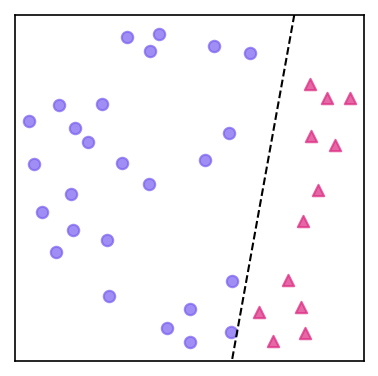

In [26]:

from rozlib.libs.plotting.utils_latex_matplot import config_matplot_for_latex, FigSaver

# aap, eap -- note reversed from other orderings
leonie_colors = ['#785EF0', '#DC267F',]

config_matplot_for_latex(14)
_topk_idcs = get_topk_indices(abs(aap_avg-eap_avg), 5)
# run do_correct first
plot_2d_tensors_umap(non_causal_exs, 'euclidean', 10, 0.1, aggregate=False,
                     random_state=6,
                     # title=f"dims: {d}",
                     label_points=False,
                     ax=None,
                     add_ax_titles=False,
                     figsize=(3,3),
                     s=30,
                     savefigname=f"eap_aap_umap_{do_correct}.pdf",
                     add_svm=True,
                     add_markers=True,
                     colors=leonie_colors
                     )


/Users/jsrozner/docs_local/research/proj_code/rozner-mono-cxs-main/rozlib-python/rozlib/libs/plotting/utils_latex_matplot.py:44: UserWarning: /Library/TeX/textbin will be added to path
  warnings.warn(f"/Library/TeX/textbin will be added to path")
/opt/homebrew/Caskroom/miniconda/base/envs/2024_coelm/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/58/nkm5hbs97tz3vc0x5l5zl4w40000gn/T/ipykernel_36232/2705752926.py:95: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(
/opt/homebrew/Caskroom/miniconda/base/envs/2024_coelm/lib/python3.12/site-packages/umap/umap_.py:1952: Use

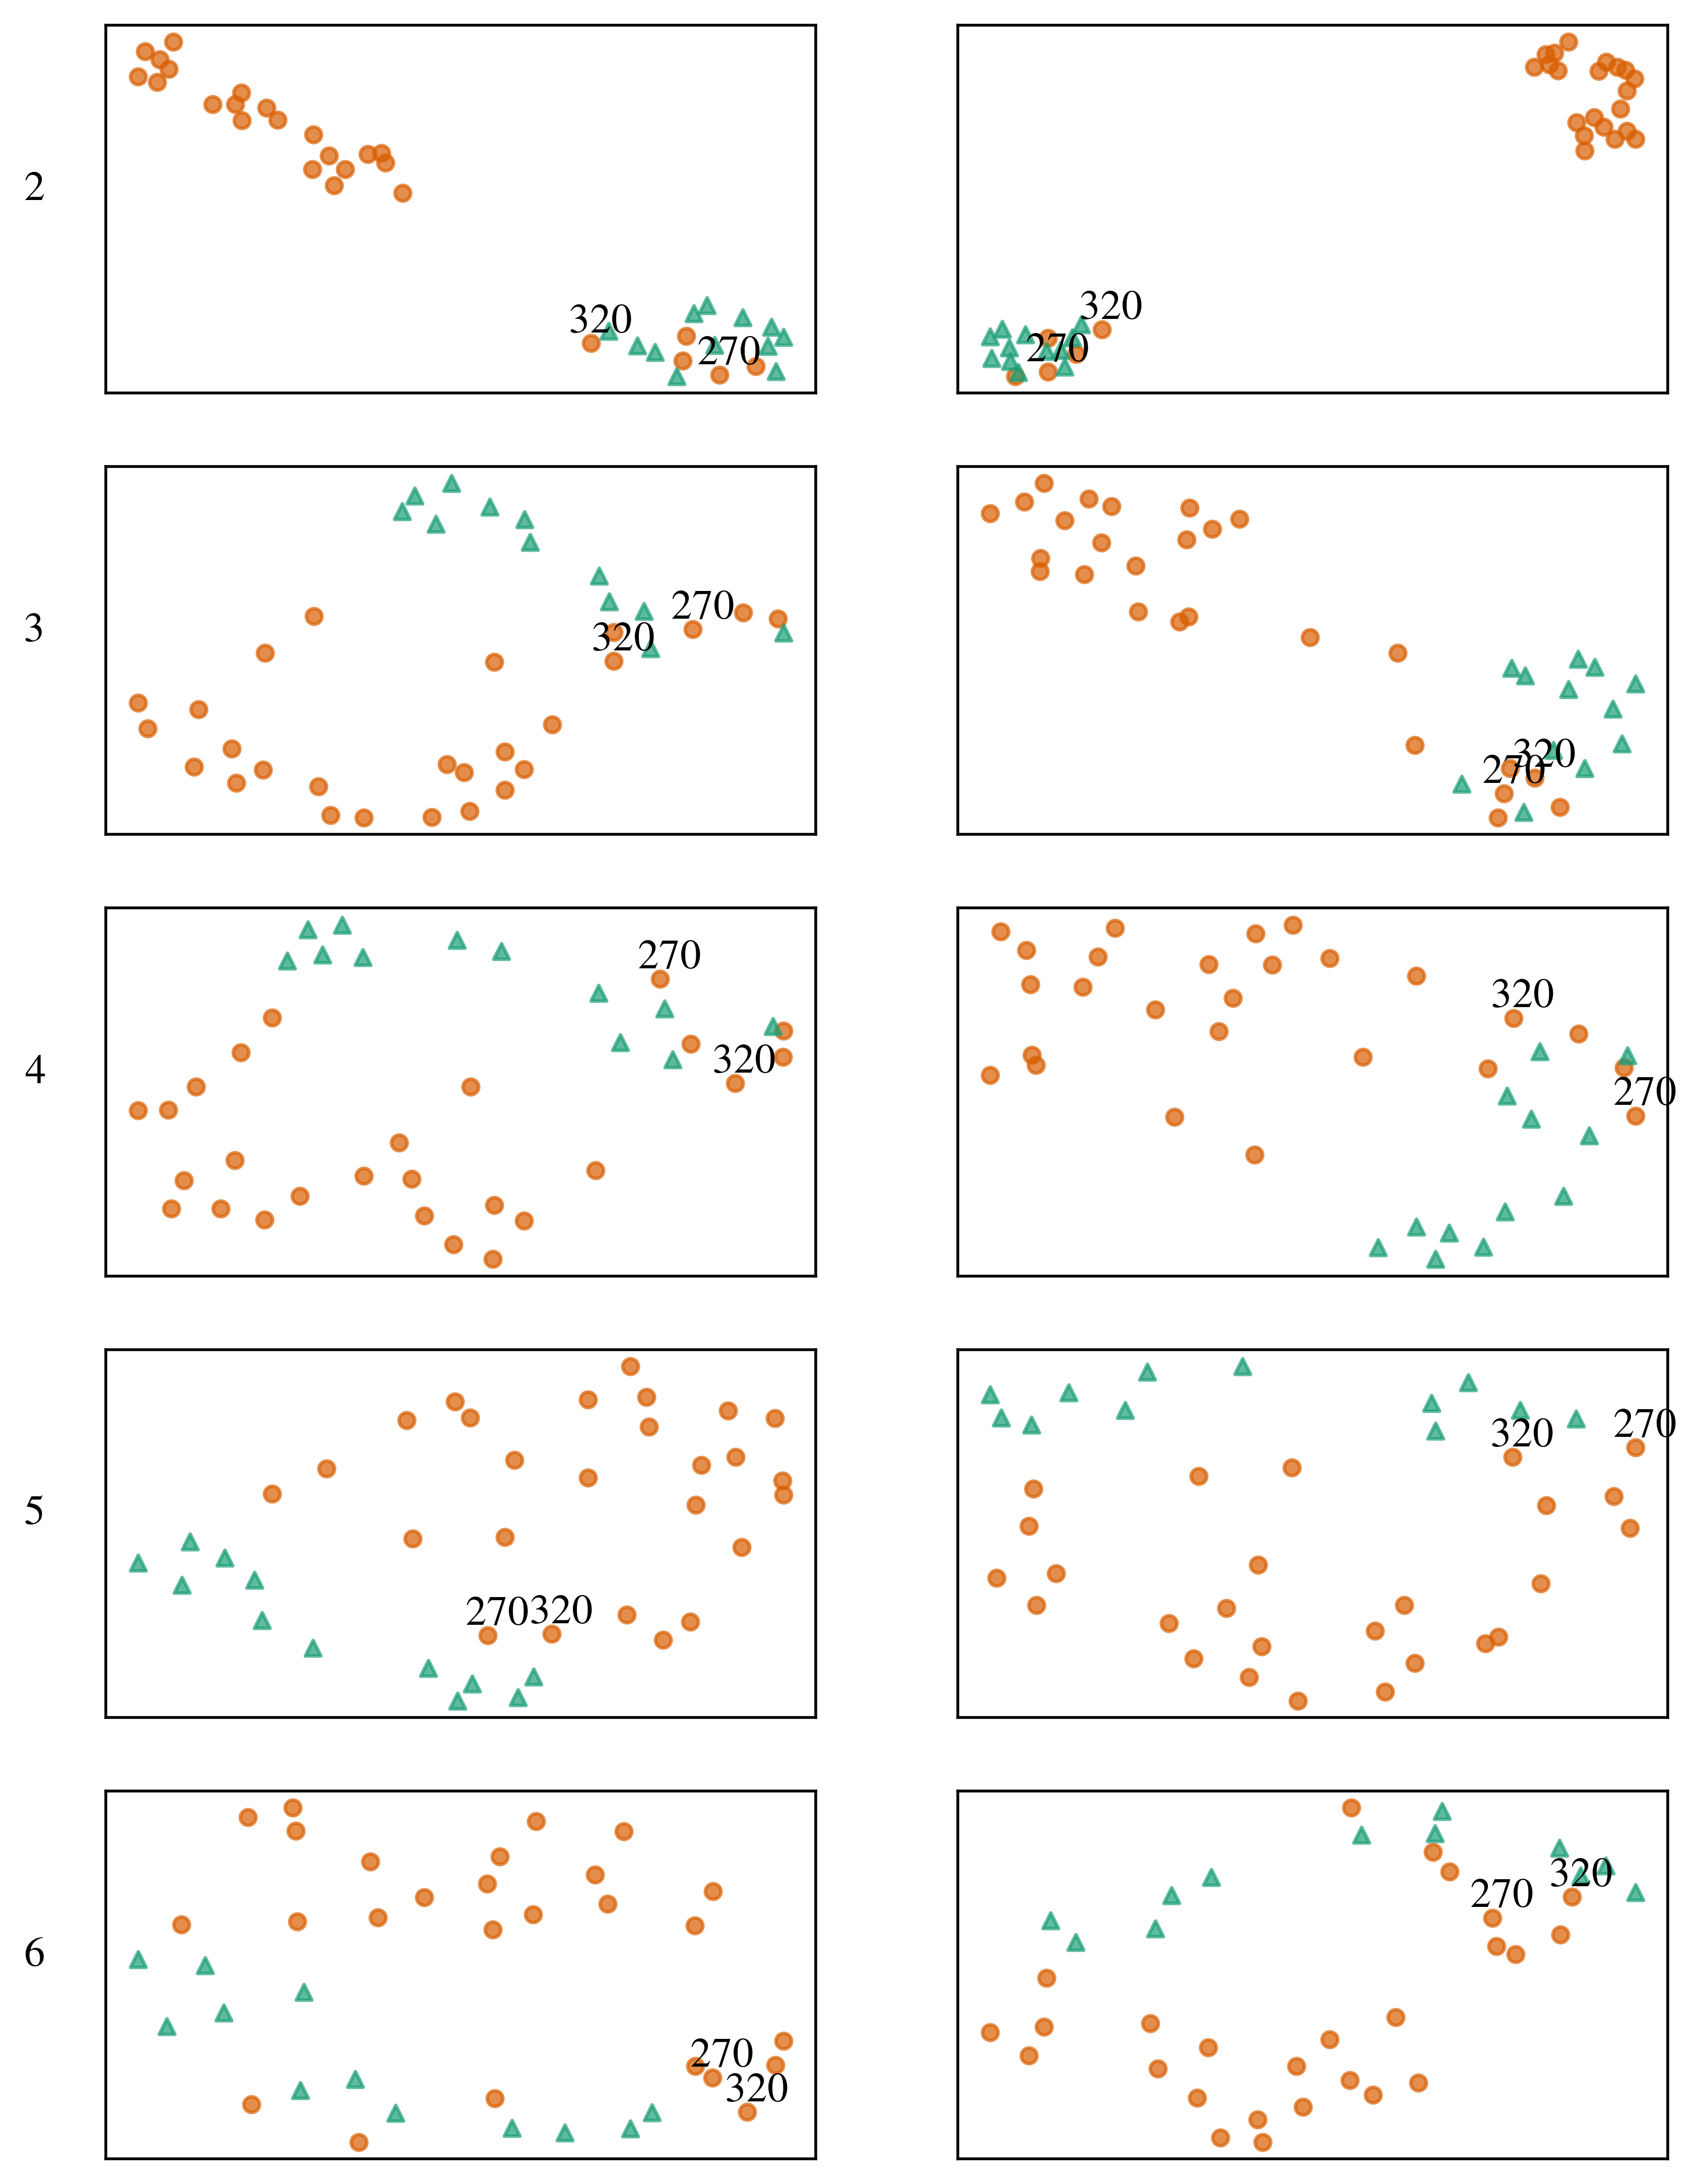

In [34]:


# 4 with random seed 2
# _topk_idcs = get_topk_indices(abs(aap_avg-eap_avg), 20)
# print(_topk_idcs)

dims = list(range(2,7))
plots = list(range(0,2))
fig, axes = plt.subplots(len(dims), len(plots), figsize=(8, 11))
i = 0

# make reproducible
rng = np.random.default_rng(42)
# higher dpi looks bad
config_matplot_for_latex(14, legend_font_change=2, dpi=100)
for i, d in enumerate(dims):
    for j,p in enumerate(plots):
        _topk_idcs = get_topk_indices(abs(aap_avg-eap_avg), d)
        ax = axes[i, j]
        plot_2d_tensors_umap(non_causal_exs, 'euclidean', 10, 0.1, aggregate=False,
                             random_state=rng.integers(0, 1000000),
                             # title=f"dims: {d}",
                             label_points=True,
                             ax=ax,
                             figsize=(8/len(plots),11/len(dims)),
                             s=20
                             )
        # todo not sure why we needed
        ax.grid = False
        for spine in ax.spines.values():
            spine.set_color('black')
for d, ax in zip(dims, axes[:,0]):
    ax.set_ylabel(d, rotation=0, labelpad=20)
# todo
# save_fig(fig, f"umap_appendix_multi_{do_correct}.pdf")
# plot_2d_tensors_umap(data_for_plot, 'euclidean', 10, 0.1, aggregate=True)


# heatmap
adapted from exp1_extract_umap_including_other_approaches for Leonie's job talk 4/30 (dunno why we hadn't ported it over originally)

/Users/jsrozner/docs_local/research/proj_code/rozner-mono-cxs-main/rozlib-python/rozlib/libs/plotting/utils_latex_matplot.py:44: UserWarning: /Library/TeX/textbin will be added to path
  warnings.warn(f"/Library/TeX/textbin will be added to path")
/var/folders/58/nkm5hbs97tz3vc0x5l5zl4w40000gn/T/ipykernel_36232/3268820412.py:44: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Initializing fig saver at dir .


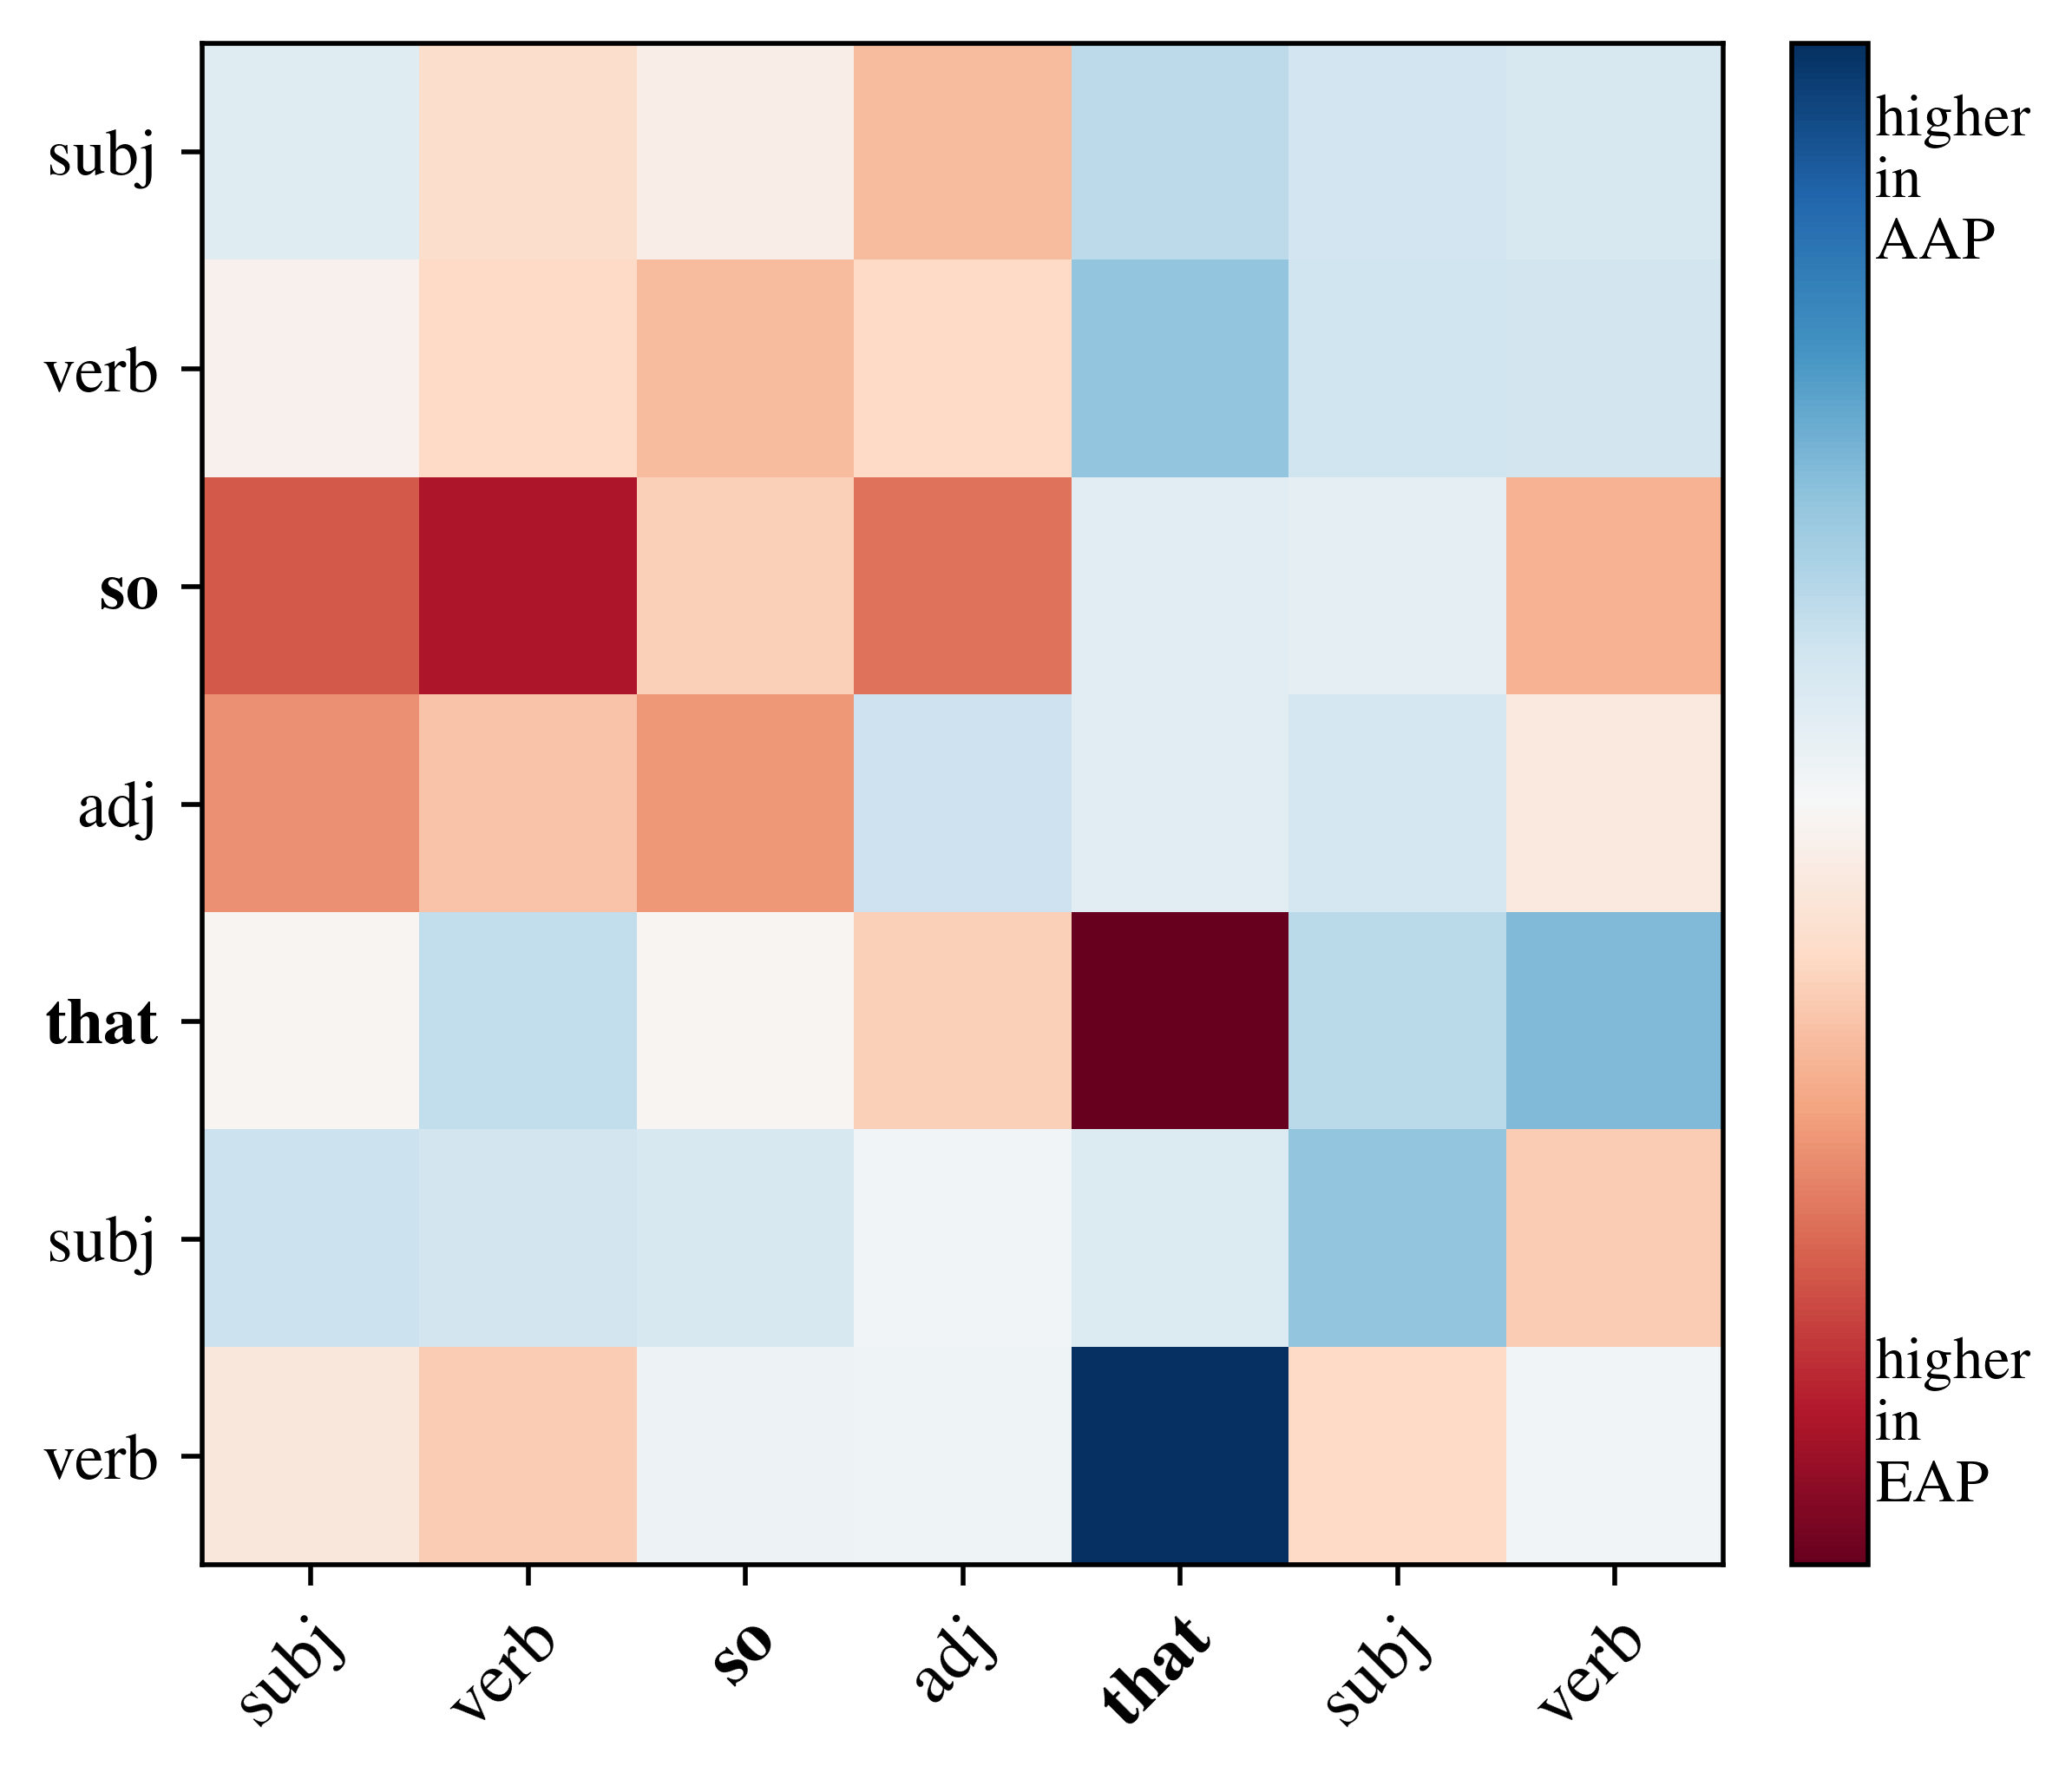

In [33]:
from pathlib import Path
from lib.plotting.plot_corr_matrix import plot_heatmap
config_matplot_for_latex(12, legend_font_change=0, dpi=500)
labels = [
    "subj",
    "verb",
    r"\textbf{so}",
    "adj",
    r"\textbf{that}",
    "subj",
    "verb"
]
# plot_heatmap(abs(aap_avg-eap_avg), labels, labels, cmap='coolwarm')
fig = plot_heatmap(
    # abs(aap_avg-eap_avg),
    aap_avg-eap_avg,
    labels,
    None,
    # cmap='Grays',
    cmap='RdBu',
    # add_colorbar=False,
    add_colorbar=True,
    fig_size=(4,4),
    return_fig=True,
    xlabel_rotation=45
    # title="Abs(avg(aap) - avg(eap))"
)

def label_color_bar(fig):
    ax = fig.axes[0]       # first Axes: main heatmap
    cbar_ax = fig.axes[1]  # second Axes: colorbar

    # Remove ticks from colorbar
    cbar_ax.tick_params(size=0, labelleft=False, labelright=False, labelbottom=False, labeltop=False)

    # Add label to colorbar
    # cbar_ax.set_ylabel("avg(AAP) - avg(EAP)", rotation=270, labelpad=15,
    #                    # , fontsize=12
    #                    )
    cbar_ax.text(1.1, 0.85, "higher\nin\nAAP", ha='left', va='bottom', transform=cbar_ax.transAxes)
    cbar_ax.text(1.1, 0.15, "higher\nin\nEAP", ha='left', va='top', transform=cbar_ax.transAxes)

label_color_bar(fig)
fig.show()

fs = FigSaver(Path(""))
fs.save(fig, "eap_aap_heatmap_color_legend.png")
